In [1]:
import pandas as pd
from topics_api_simulator.simulator import Simulator
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Topics API simulator

In this notebook, we illustrate how to calculate the risk probabilities of users exposed to the Topics API ecosystem. Please refer to code documentation and to the paper for any additional detail.

In [2]:
# the dataset to be used as input
# as a starting point, a user x topic matrix is used
# each cell contains the average visiting rate in an epoch for every user and topic
# at the moment, we assume visiting rates to be stationary
DF = pd.read_csv('lambda-user-topic.csv').values

#default parameters for the simulation
params = {
    'nusers': 1000,
    'z': 5,
    'nepochs': 40,
    'p': .05,
    'taxonomy': 'v1',
    'pmin': 1e-5,
    'thresh': 2,
    'method': 'iid'
}

seeds = [1,32,345,85,347,128,24,729,283,90]

## $Prob(re-identification)$

The model can also be used to estimate directly the probability of a user to be re-identified by an attacker using two colluding websites.

We compare three possible attacks:

- The *Strict* Attack: if a website contains a unique denoised reconstructed profile that matches with another unique profile on the other website, this is considered to be a match.
- The *Loose* Attack: to have a match, the denoised reconstructed profile on the first website must be a subset of the global reconstructed profile on the second website, and viceversa. The two denoised profiles must be unique in each website.
- The Asymmetric Weighted Hamming Attack: attack devised by Google (Topics API's proponent), please refer to [the original paper](https://dl.acm.org/doi/pdf/10.1145/3589294) for details.

The attacks models are compared considering both the probability of *correctly* identifying users, and the probability of *incorrectly* identify them. The Topics API and environment parameters can be tuned to observe the evolution in the $Prob(re-identification)$. We use the I.I.D. user-generating method to produce these results. Please refer to the paper for details.

In [3]:
%%time
##############################################################
###################### COMPARE METHODS #######################
##############################################################

metrics = ['awha','strict', 'loose']
methods = ['iid', 'crossover']

tps_per_seed_strict = []
fps_per_seed_strict = []

tps_per_seed_loose = []
fps_per_seed_loose = []

tps_per_seed_awha = []
fps_per_seed_awha = []

for seed in tqdm(seeds):
    
    sim = Simulator(DF, params, seed=seed)
    
    tp_strict, fp_strict = sim.strict_attack(denoising=True, verbose=False)
    tp_loose, fp_loose = sim.loose_attack(denoising=True, verbose=False)
    tp_awha, fp_awha = sim.asymmetric_weighted_hamming_attack(verbose=False)
    
    tps_per_seed_strict.append(tp_strict)
    fps_per_seed_strict.append(fp_strict)
        
    tps_per_seed_loose.append(tp_loose)
    fps_per_seed_loose.append(fp_loose)
        
    tps_per_seed_awha.append(tp_awha)
    fps_per_seed_awha.append(fp_awha)
    
tps_per_seed_strict = np.array(tps_per_seed_strict)
fps_per_seed_strict = np.array(fps_per_seed_strict)

tps_per_seed_loose = np.array(tps_per_seed_loose)
fps_per_seed_loose = np.array(fps_per_seed_loose)

tps_per_seed_awha = np.array(tps_per_seed_awha)
fps_per_seed_awha = np.array(fps_per_seed_awha)

100%|██████████| 10/10 [37:13<00:00, 223.34s/it]

CPU times: user 37min, sys: 12.4 s, total: 37min 13s
Wall time: 37min 13s


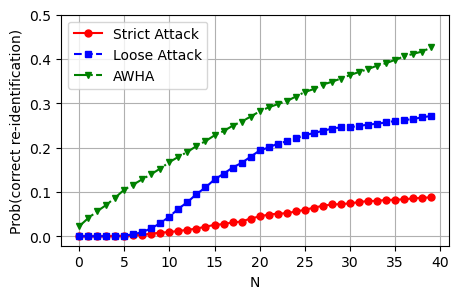

In [4]:
plt.figure(figsize=(5,3))
plt.xlabel('N')
plt.ylabel('Prob(correct re-identification)')
plt.plot(tps_per_seed_strict.mean(axis=0), '-o', c='r', markersize=5, label='Strict Attack')
plt.plot(tps_per_seed_loose.mean(axis=0), '--s', c='b', markersize=5, label='Loose Attack')
plt.plot(tps_per_seed_awha.mean(axis=0), '-.v', c='g', markersize=5, label='AWHA')
plt.ylim(top=.5)
plt.legend()
plt.grid()
plt.show()

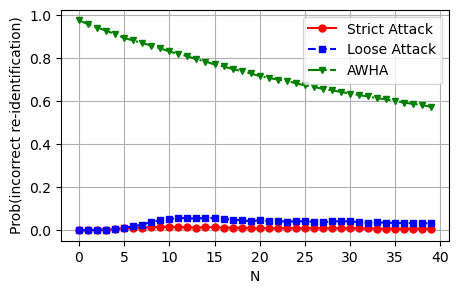

In [5]:
plt.figure(figsize=(5,3))
plt.xlabel('N')
plt.ylabel('Prob(incorrect re-identification)')
plt.plot(fps_per_seed_strict.mean(axis=0), '-o', c='r', markersize=5, label='Strict Attack')
plt.plot(fps_per_seed_loose.mean(axis=0), '--s', c='b', markersize=5, label='Loose Attack')
plt.plot(fps_per_seed_awha.mean(axis=0), '-.v', c='g', markersize=5, label='AWHA')
plt.legend()
plt.grid()
plt.show()

## $Prob(k-anon)$

The module can also be used to evaluate the probability of a user being $k$-anonymous among the users that visited a website.

In the following example, we use the $k$ itself, but please note that other environmental and design parameters (such as the number of users $|U|$, or the probaiblity of exposing a random topic $p$) can be tested.

In [6]:
methods = ['iid','crossover']
# define a range of ks
ks = range(2,11)

pkanons_per_seed = []
# for every seed
for seed in tqdm(seeds):
    pkanons_per_method = []
    # for both the methods
    for method in methods:
        
        params['method'] = method
        sim = Simulator(DF, params, seed=seed)
        
        pkanons_per_k = []
        for k in ks:
            
            pkanons = sim.get_prob_kanon(k=k)
            pkanons_per_k.append(pkanons)
        
        pkanons_per_method.append(pkanons_per_k)
        
    pkanons_per_seed.append(pkanons_per_method)
    
pkanons_per_seed = np.array(pkanons_per_seed)

100%|██████████| 10/10 [01:31<00:00,  9.19s/it]


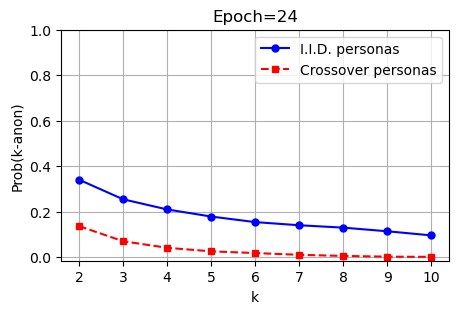

In [7]:
epoch = 24
plt.figure(figsize=(5,3))
plt.title(f'Epoch={epoch}')
plt.xlabel('k')
plt.ylabel('Prob(k-anon)')
plt.plot(ks, pkanons_per_seed.mean(axis=0)[0,:,epoch], '-o', c='b', markersize=5, label='I.I.D. personas')
plt.plot(ks, pkanons_per_seed.mean(axis=0)[1,:,epoch], '--s', c='r', markersize=5, label='Crossover personas')
plt.ylim(top=1.)
plt.legend()
plt.grid()
plt.show()